<a href="https://colab.research.google.com/github/JohnCordero1/Finanzas_Pronosticos/blob/main/Microsoft_Prediccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pronóstico de series de tiempo con Prophet Introducción:**

En este Jupyter Notebook pronosticaremos los precios de las acciones usando Prophet (la biblioteca de Facebook para pronósticos de series de tiempo). Normalmente se usa los precios históricos para pronosticar la subida o caida de un activo financiero en particular, este tipo de operaciones se utilizan usualmente en el "Análisis Técnico"; sin embargo, los precios históricos no siempre son una buena indicación sobre el rumbo que tomará este activo financiero en particular, por lo menos hay una buena razón para creer que esta operación no es la más adecuada, pues la filosofía con la que se construye los análisis técnicos describen que la historia se repite y se lo puede comprobar viendo el comportamiento de un activo en dos distintos periodos. Si bien, puede sonar razonable el hecho de que los humanos se comporten de manera similar ante determinados *shocks*, mi estudio en Economía me hace creer que no deberia ser la regla, pues dejariamos a un lado una importante caracteristica del humano, la racionalidad con la que actuan. Para ello en este cuaderno se usará distintas variables y se utilizará el aprendizaje automático para predecir el precio de las acciones en lugar de simplemente usar los precios históricos como una indicación del aumento del precio de las acciones.

**Un resumen sobre Prophet:**

el equipo de investigación de Facebook ha ideado una implementación más sencilla de pronóstico a través de su nueva biblioteca llamada Prophet. La razón que los llevó a contruirlo es debido a que rara vez se cuenta con pronosticos de buena calidad. Esta es una de las razones por las que el equipo de investigación de Facebook encontró una manera fácilmente accesible para usar conceptos avanzados para el pronóstico de series de tiempo y nosotros, los usuarios de Python, podemos relacionarnos fácilmente con esta biblioteca ya que utiliza la API de Scikit-Learn (similar a Scikit-Learn). Para obtener más información, puede consultar el Blog de Prophet. El objetivo principal del equipo de Prophet es facilitar que expertos y no expertos realicen pronósticos de alta calidad que se mantengan al día con la demanda.

Hay varias características de Prophet (puedes verlas en el blog) que quiero compartir contigo Kaggles que muestran dónde funciona mejor Prophet:

- Observaciones horarias, diarias o semanales con al menos algunos meses (preferiblemente un año) de historia
- Estaciones fuertes múltiples a “escala humana”: día de la semana y época del año
- Días festivos importantes que ocurren a intervalos irregulares que se conocen de antemano (p. ej. Super Bowl)
- Un número razonable de observaciones faltantes o grandes valores atípicos
- Cambios de tendencias históricas, por ejemplo debido a lanzamientos de productos
- O cambios en el registro Tendencias que son curvas de crecimiento no lineales, donde una tendencia alcanza un límite natural o se satura

In [18]:
!pip install prophet

In [19]:
!pip install chart-studio

In [21]:
# Importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
# Importar Statsmodelos junto a otras funciones especificas
import statsmodels.api as sm
from scipy import stats
#from pandas.core import datetools
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

# Un fondo predeterminado para los gráficos
plt.style.use("seaborn-whitegrid")

#Importar datos desde la API de Yahoo Finance
import yfinance as yf

In [22]:
#Importar datos de Microsoft (MSFT)
msft = yf.download('MSFT', period='max')
msft.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063503,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061888,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060812,47894400


In [23]:
#Estadisiticas descriptivas de nuestro conjunto de datos
msft.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9554.000000,9554.000000,9554.000000,9554.000000,9554.000000,9.554000e+03
mean,53.883657,54.454834,53.305571,53.900902,48.410132,5.723494e+07
std,80.901398,81.708011,80.077554,80.935956,81.028576,3.814465e+07
min,0.088542,0.092014,0.088542,0.090278,0.055969,2.304000e+06
25%,5.571290,5.673828,5.460938,5.585938,3.463079,3.277602e+07
50%,27.219999,27.490000,27.000000,27.250000,19.139906,5.035160e+07
75%,45.757499,46.309375,45.156250,45.754999,36.398695,7.117560e+07
max,414.049988,415.559998,412.529999,414.109985,414.109985,1.031789e+09


En este caso, nuestro "Date" esta como el indice de nuestras filas, a la vez que necesitamos tener una columna de fecha para poder trabajar con los gráficos. Una solución a esto es construir una columna de "Date" a partir del índice, esta nueva columna tendrá el formato de tipo objeto, por ello le daremos un formato fecha mas adelante.

In [24]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9554 entries, 1986-03-13 to 2024-02-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9554 non-null   float64
 1   High       9554 non-null   float64
 2   Low        9554 non-null   float64
 3   Close      9554 non-null   float64
 4   Adj Close  9554 non-null   float64
 5   Volume     9554 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 522.5 KB


In [25]:
# Convertir el índice a una columna llamada 'Date' sin información de la hora
msft['Date'] = msft.index.date

In [26]:
msft.head()

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800,1986-03-13
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062427,308160000,1986-03-14
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063503,133171200,1986-03-17
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061888,67766400,1986-03-18
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060812,47894400,1986-03-19


In [36]:
msft.tail()

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2024-02-02,403.809998,412.649994,403.559998,411.220001,411.220001,28245000,2024-02-02
2024-02-05,409.899994,411.160004,403.989990,405.649994,405.649994,25352300,2024-02-05
2024-02-06,405.880005,407.970001,402.910004,405.489990,405.489990,18382600,2024-02-06
2024-02-07,407.440002,414.299988,407.399994,414.049988,414.049988,22340500,2024-02-07
2024-02-08,414.049988,415.559998,412.529999,414.109985,414.109985,17608580,2024-02-08


In [27]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9554 entries, 1986-03-13 to 2024-02-08
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9554 non-null   float64
 1   High       9554 non-null   float64
 2   Low        9554 non-null   float64
 3   Close      9554 non-null   float64
 4   Adj Close  9554 non-null   float64
 5   Volume     9554 non-null   int64  
 6   Date       9554 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 597.1+ KB


In [28]:
#Convertimos la columna "Date" en formato fecha
msft.loc[:, 'Date'] = pd.to_datetime(msft.loc[:,'Date'], format="%Y/%m/%d")

In [29]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9554 entries, 1986-03-13 to 2024-02-08
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       9554 non-null   float64       
 1   High       9554 non-null   float64       
 2   Low        9554 non-null   float64       
 3   Close      9554 non-null   float64       
 4   Adj Close  9554 non-null   float64       
 5   Volume     9554 non-null   int64         
 6   Date       9554 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 597.1 KB


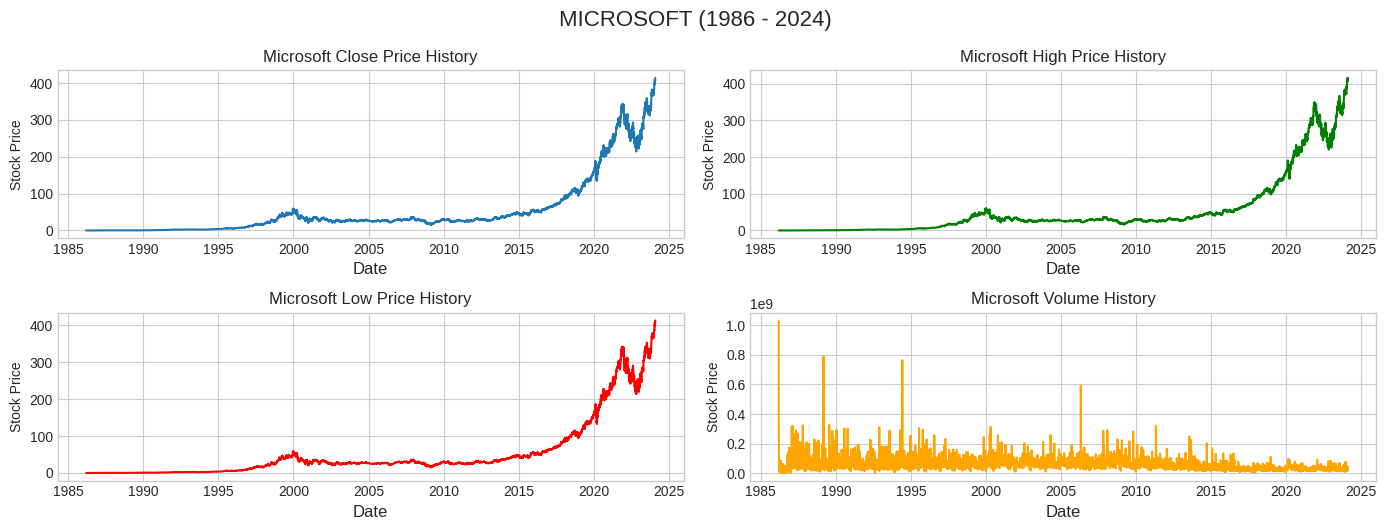

In [30]:
# Realizamos un gráfico simple
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,5))

#Primer Subplot
ax1.plot(msft["Date"], msft["Close"])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Microsoft Close Price History")

# Segundo Subplot
ax2.plot(msft["Date"], msft["High"], color="green")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("Microsoft High Price History")

# Tercer Subplot
ax3.plot(msft["Date"], msft["Low"], color="red")
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Stock Price")
ax3.set_title("Microsoft Low Price History")

# Cuarto Subplot
ax4.plot(msft["Date"], msft["Volume"], color="orange")
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Stock Price")
ax4.set_title("Microsoft Volume History")

#Algunos ajustes al gráfico
fig.tight_layout() #Ajustar ejes
fig.suptitle('MICROSOFT (1986 - 2024)', fontsize=16, y=1.05)

plt.show()

Introducción a Prophet: Prophet es la biblioteca de Facebook para pronósticos de series temporales. Podemos ver la simplicidad de usar Prophet para realizar pronósticos simples, que es el objetivo principal de este núcleo.

Pasos para usar Prophet:
- Meta nos recomienda usar "Close Price" para "y" y la "Date" para "ds".
- Ajuste ese marco de datos a Prophet para detectar patrones futuros.
- Predecir los precios superior e inferior del precio de cierre.

In [31]:
#Nuevo DF con las columnas de nuestro interés
msft_1 = msft.drop(['Open', 'High', 'Low', 'Volume', 'Adj Close'], axis=1)
msft_1.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

msft_1.head()

,y,ds
Date,,
1986-03-13,0.097222,1986-03-13
1986-03-14,0.100694,1986-03-14
1986-03-17,0.102431,1986-03-17
1986-03-18,0.099826,1986-03-18
1986-03-19,0.098090,1986-03-19


In [32]:
#Instanciamos Prophet
m = Prophet()
# Usamos fit al igual que cualquier algoritmo de ML
m.fit(msft_1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph86odeud/5wjt6f9f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph86odeud/_rqc2gdg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74104', 'data', 'file=/tmp/tmph86odeud/5wjt6f9f.json', 'init=/tmp/tmph86odeud/_rqc2gdg.json', 'output', 'file=/tmp/tmph86odeud/prophet_modeltj9n5vsn/prophet_model-20240208233944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:39:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [33]:
# Crear futuros datos
future_prices = m.make_future_dataframe(periods=365)

# Prediccion de los precios
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9914,2025-02-03,388.107870,370.673441,405.640965
9915,2025-02-04,388.176869,370.903588,404.758027
9916,2025-02-05,388.318310,372.755680,405.410934
9917,2025-02-06,388.374567,372.070568,405.677630
9918,2025-02-07,388.302885,370.246811,405.578920


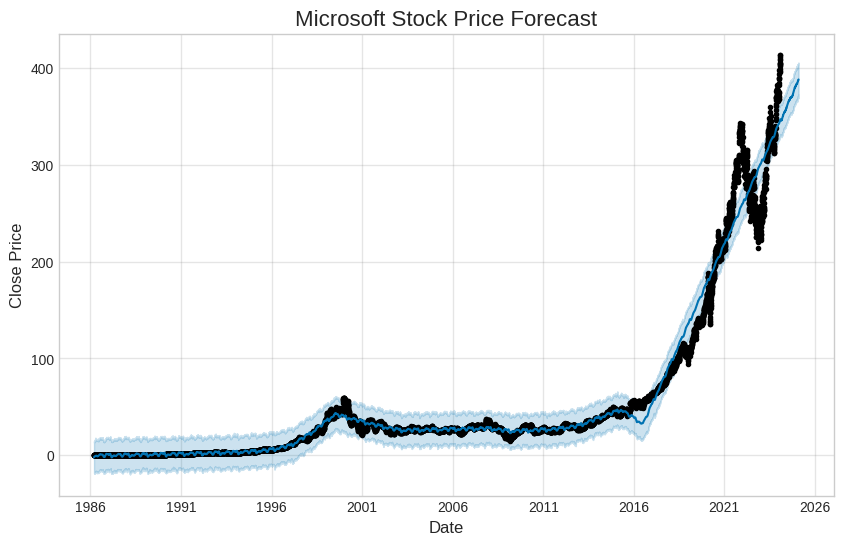

In [47]:
import matplotlib.dates as mdates
import datetime as dt

fig, ax1 = plt.subplots(figsize=(10, 6))

m.plot(forecast, ax=ax1)

ax1.set_title("Microsoft Stock Price Forecast", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Close Price", fontsize=12)

plt.show()

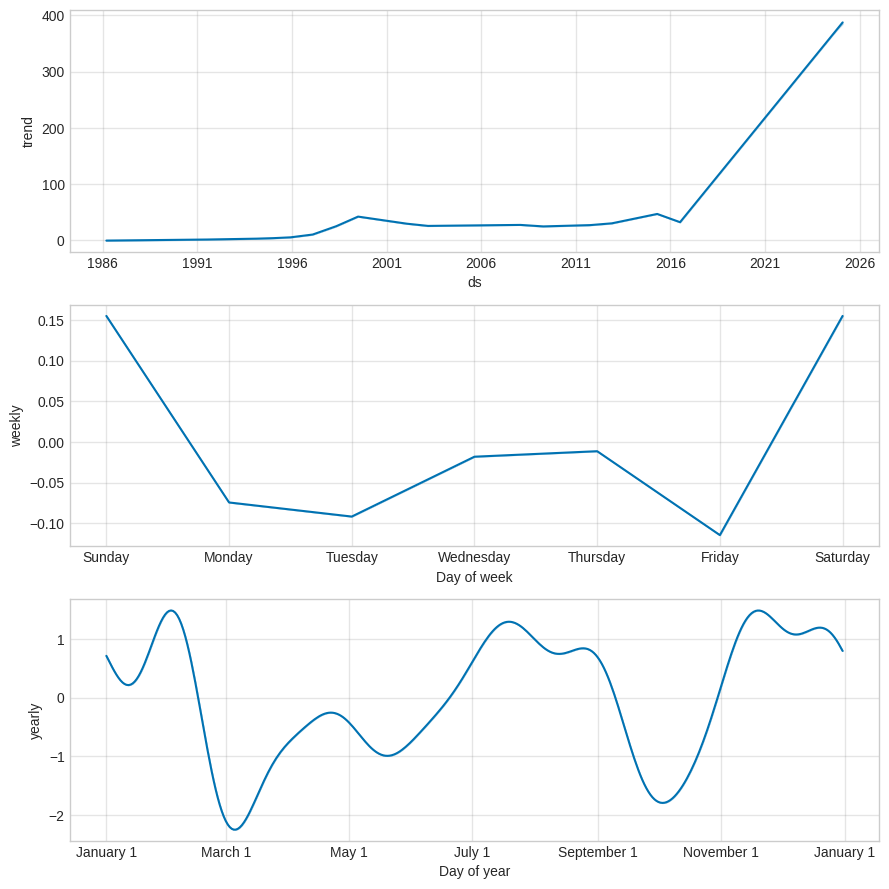

In [48]:
fig2 = m.plot_components(forecast)
plt.show()


Se puede observar que el precio de las acciones de Microsoft presenta una tendencia alcista, significativa, a partir del año 2018. Así tambien, los precios de las acciones tienden a presentar tendencias alcistas durante los meses de Enero (posiblemente por festejos de fin de año).

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph86odeud/lfiosw7m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph86odeud/r_j5l7mb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67531', 'data', 'file=/tmp/tmph86odeud/lfiosw7m.json', 'init=/tmp/tmph86odeud/r_j5l7mb.json', 'output', 'file=/tmp/tmph86odeud/prophet_model7zbpif8r/prophet_model-20240209001706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:17:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:17:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


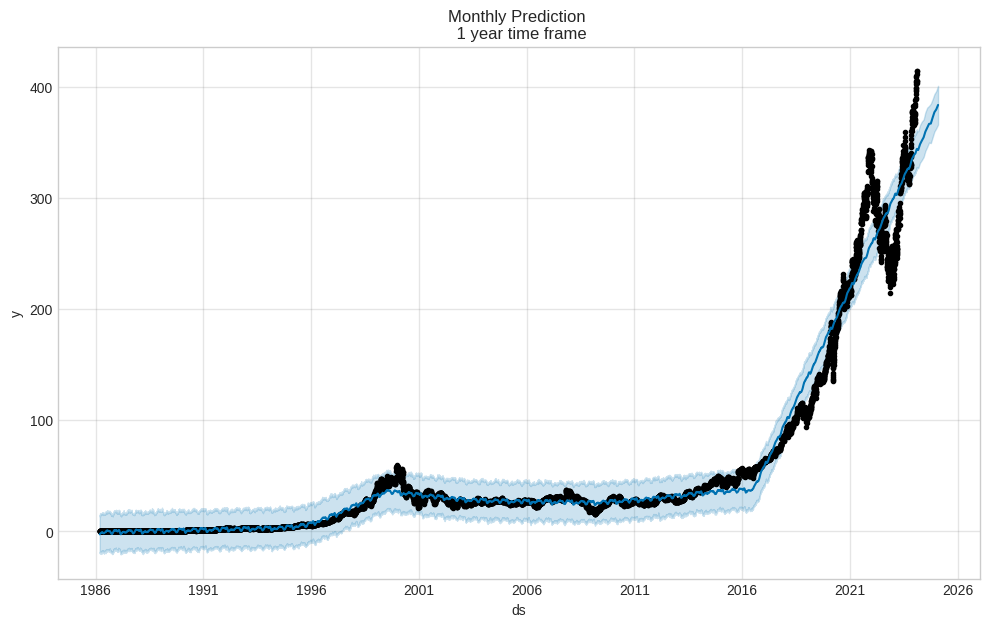

In [49]:
# Predicciones de datos mensuales
m = Prophet(changepoint_prior_scale=0.01).fit(msft_1)
future = m.make_future_dataframe(periods=12, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)
plt.title("Monthly Prediction")

plt.show()

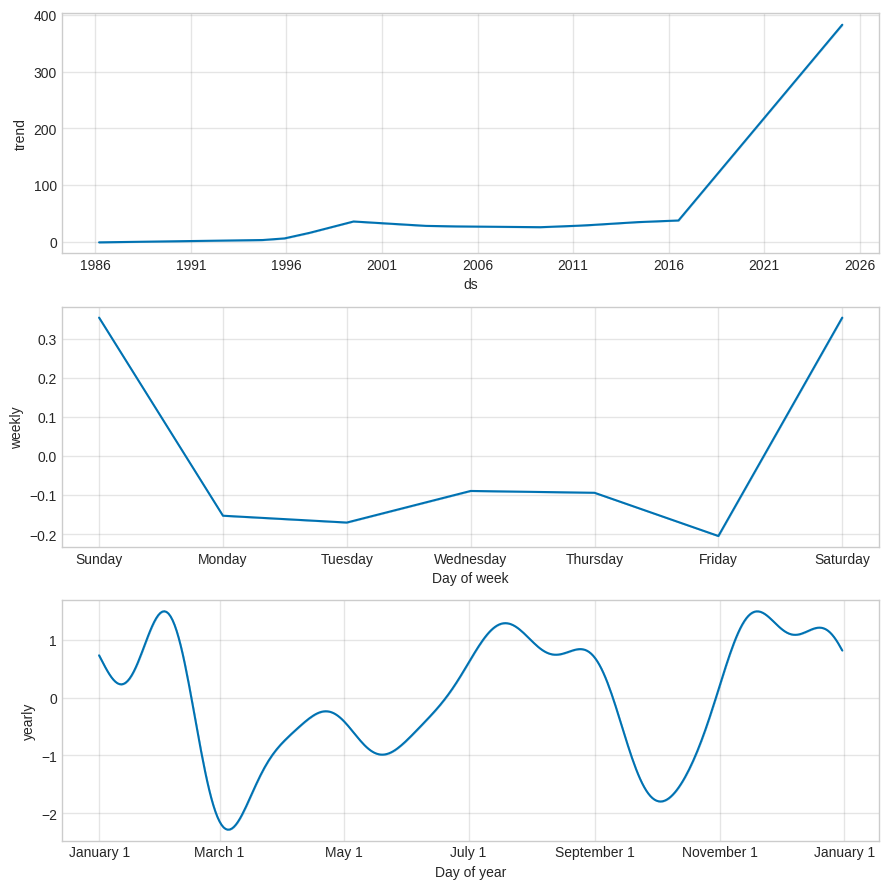

In [50]:
fig = m.plot_components(fcst)
plt.show()

**Análisis técnico:**

En esta sección utilizaremos algunos conceptos básicos del análisis técnico básicos a la hora de invertir en acciones. Estas son teorías simples, sin embargo, como ya mencionó anteriormente, no deberíamos confiar únicamente en estos conceptos para maximizar las ganancias, como es el caso de los patrones relacionados con las medias móviles.

Para ello se usará los conceptos de "Open High Low Close" (precios de Apertura, Máximo, Mínimo, Cierre), de este tipo de gráficos se derivan las velas japonesas, medias moviles, entre otros.

In [59]:
import plotly.offline as pyo
import plotly.graph_objects as go

# Inicializar Plotly para el modo offline en Jupyter Notebook
pyo.init_notebook_mode(connected=True)


trace = go.Figure( data =[go.Candlestick(
                          x=msft.index,
                          open=msft['Open'],
                          high=msft['High'],
                          low=msft['Low'],
                          close=msft['Close'],
                          increasing=dict(line=dict(color= '#58FA58')),
                          decreasing=dict(line=dict(color= '#FA5858'))
)])

layout = {
    'title': 'Microsoft Historical Price',
    'xaxis': {'title': 'Date', 'rangeslider': {'visible': False}},
    'yaxis': {'title': 'Stock Price (USD$)'}
}
trace.show()

In [ ]:
last_two = msft.loc[msft['Date'].dt.year > 2016]

g = last_two.groupby(["Date"])
monthly_averages = g.aggregate({"Open": np.mean, "High": np.mean, "Low": np.mean, "Close":np.mean})
monthly_averages.reset_index(level=0, inplace=True)

trace = go.Candlestick(x=monthly_averages['Date'],
                       open=monthly_averages['Open'].values.tolist(),
                       high=monthly_averages['High'].values.tolist(),
                       low=monthly_averages['Low'].values.tolist(),
                       close=monthly_averages['Close'].values.tolist(),
                      increasing=dict(line=dict(color= '#58FA58')),
                decreasing=dict(line=dict(color= '#FA5858')))

layout = {
    'title': 'Microsoft Historical Price <br> <i>For the Last two years </i>',
    'xaxis': {'title': 'Date',
             'rangeslider': {'visible': False}},
    'yaxis': {'title': 'Stock Price (USD$)'},
    'shapes': [{
        'x0': '2018-01-02', 'x1': '2018-01-02',
        'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
        'line': {'color': 'rgb(30,30,30)', 'width': 1}
    }],
    'annotations': [{
        'x': '2018-01-07', 'y': 0.9, 'xref': 'x', 'yref': 'paper',
        'showarrow': True, 'xanchor': 'left',
        'text': 'Upward Trend'
    }]
}


data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')

In [ ]:
msft['month_year'] = pd.to_datetime(msft['Date']).dt.to_period('M')

# 2017 onwards
last_year = msft.loc[msft['Date'].dt.year > 2017]
g = last_year.groupby(["Date"])
monthly_averages = g.aggregate({"Open": np.mean, "High": np.mean, "Low": np.mean, "Close":np.mean})
monthly_averages.reset_index(level=0, inplace=True)

monthly_averages.dtypes


trace = go.Candlestick(x=monthly_averages['Date'],
                       open=monthly_averages['Open'].values.tolist(),
                       high=monthly_averages['High'].values.tolist(),
                       low=monthly_averages['Low'].values.tolist(),
                       close=monthly_averages['Close'].values.tolist(),
                      increasing=dict(line=dict(color= '#58FA58')),
                decreasing=dict(line=dict(color= '#FA5858')))


layout = {
    'title': 'Amazon Historical Price <br> <i>A closer look to the upward trend </i>',
    'xaxis': {'title': 'Date',
             'rangeslider': {'visible': False}},
    'yaxis': {'title': 'Stock Price (USD$)'}
}


data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple_ohlc')